<h1> Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Required imports for neural network
import torch.nn as nn
import torch
from torch.autograd import Variable
import random

<h1> Data Loading and Generation

This Sine function generator is based on the repostory: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

In [2]:
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
    
    def plot_model(self, new_model, *args, **kwargs):
        x, y_true = self.test_set(size=100)
        x = Variable(x[:, None])
        y_true = Variable(y_true[:, None])    

        y_pred = new_model(x)

        plt.plot(x.data.numpy().flatten(),
                 y_pred.data.numpy().flatten(),
                 *args, **kwargs)

TRAIN_SIZE = 20000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]

<h1> Neural Network Model

In [19]:
# Define network
class Neural_Network(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=2):
        super(Neural_Network, self).__init__()
        # network layers
        self.hidden1 = nn.Linear(input_size,hidden_size)
        self.hidden2 = nn.Linear(hidden_size,hidden_size)
        self.hidden3 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.hidden3(x)
        x = self.relu(x)
        x = self.output_layer(x)
        mean = x[:,0][:,None] 
        std = self.relu(x[:,1][:,None]) 
        return mean,std


<h1> Helper functions

In [50]:
import math
#https://towardsdatascience.com/predicting-probability-distributions-using-neural-networks-abef7db10eac
def loss_gaussian(mean,std,label):
  epsilon = 1e-10 #avoid division by 0
  avoid_inf = 1e-3
  a = 1/(torch.sqrt(2*math.pi*std**2)+epsilon )
  b = -((label-mean)**2)/(2*std**2+epsilon )
  loss = -torch.log(a*torch.exp(b)+avoid_inf)
  return torch.mean(loss)

In [51]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def get_samples_in_good_format(wave):
  #This function is used to sample data from a wave
  x, y_true = wave.training_set()
  # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
  # Note that we convert everything torch tensors
  x = torch.tensor(x[:,None])
  y_true = torch.tensor(y_true[:,None])
  return x,y_true

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, item = True):
    # Get data
    x, label = get_samples_in_good_format(wave)
    # Make model prediction
    mean,std = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = loss_gaussian(mean,std,label).item()
    else:
      loss = loss_gaussian(mean,std,label)
    return loss

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

<h1> Reptile

In [52]:
#Define important variables
epochs = int(1e5) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=1000 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

# Initializations
initialization_to_store_meta_losses()
model = Neural_Network()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [60]:
# Initializations
initialization_to_store_meta_losses()
model = Neural_Network()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [61]:
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=100 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

In [65]:
# Training loop
T = 10
for epoch in range(1000000):
        
    # Sample a sine wave (Task from training data)
    wave = random.sample(SINE_TRAIN, T)

    # Update model predefined number of times based on k
    new_model = training(model, wave[0], lr_k, k)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,wave[0],store_train_loss_meta)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the wave from the test data
    wave = random.sample(SINE_TEST, 1)
    test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epochh : 0, Average Train Meta Loss : 0.8178308121860027, Average Test Meta Loss : 1.1398650407791138
Epochh : 100, Average Train Meta Loss : 1.6173798925465062, Average Test Meta Loss : 1.5393028413452725
Epochh : 200, Average Train Meta Loss : 1.6465531480748479, Average Test Meta Loss : 1.600215228339333
Epochh : 300, Average Train Meta Loss : 1.65055178153466, Average Test Meta Loss : 1.6258989883481565
Epochh : 400, Average Train Meta Loss : 1.6798679040445958, Average Test Meta Loss : 1.6579290848095296
Epochh : 500, Average Train Meta Loss : 1.7087893894845896, Average Test Meta Loss : 1.6564045054968186
Epochh : 600, Average Train Meta Loss : 1.7130623998843935, Average Test Meta Loss : 1.622899954779052
Epochh : 700, Average Train Meta Loss : 1.704875602293099, Average Test Meta Loss : 1.6260643548407883
Epochh : 800, Average Train Meta Loss : 1.7010266816856698, Average Test Meta Loss : 1.649335198618295
Epochh : 900, Average Train Meta Loss : 1.72341473398123, Average Test M

KeyboardInterrupt: ignored

<h1> Few Shot learning with new meta-model

The model performs good few shot learning

In [63]:
wave = SineWaveTask(); 
k_shot_updates = 4
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model, wave, lr_k, shots)
    train_set_evaluation(new_model,wave,store_train_loss_meta) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Text(0.5, 0, 'k shots')

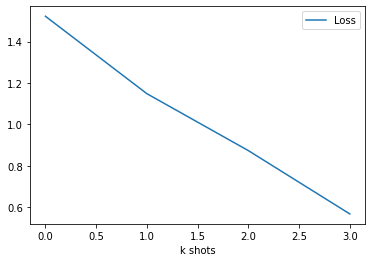

In [64]:
plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')